In [1]:
import pandas as pd
import numpy as np

In [2]:
train_data = pd.read_csv('2006-2019')
train_data.head()

,Date,Symbol,Open,High,Low,Last,Close,Volume,Turnover,%Deliverable
0,2007-11-27,MUNDRAPORT,770.00,1050.00,770.0,959.0,962.90,27294366,2.687719e+15,0.3612
1,2007-11-28,MUNDRAPORT,984.00,990.00,874.0,885.0,893.90,4581338,4.312765e+14,0.3172
2,2007-11-29,MUNDRAPORT,909.00,914.75,841.0,887.0,884.20,5124121,4.550658e+14,0.2088
3,2007-11-30,MUNDRAPORT,890.00,958.00,890.0,929.0,921.55,4609762,4.283257e+14,0.2735
4,2007-12-03,MUNDRAPORT,939.75,995.00,922.0,980.0,969.30,2977470,2.875200e+14,0.2741


In [3]:
test_data = pd.read_csv('2020-2021')
test_data.head()

,Date,Symbol,Open,High,Low,Last,Close,Volume,Turnover,%Deliverable
0,2020-01-01,ADANIPORTS,368.00,379.25,366.00,377.45,377.65,11377167,4.274459e+14,0.1016
1,2020-01-02,ADANIPORTS,377.95,384.70,376.50,382.50,383.15,5919760,2.259337e+14,0.1811
2,2020-01-03,ADANIPORTS,382.70,384.35,379.20,382.00,382.50,3684824,1.407636e+14,0.2939
3,2020-01-06,ADANIPORTS,388.00,388.00,374.75,380.00,380.20,12482680,4.765071e+14,0.1799
4,2020-01-07,ADANIPORTS,384.05,389.75,382.40,384.05,384.80,8091465,3.119178e+14,0.3743


In [4]:
def to_int_labels(df):
    labels = df["Symbol"].unique()
    
    df["Symbol"] = df["Symbol"].replace(labels, [i for i in range(len(labels))])

    return df


def add_gain_values(df):
    df["Gain Value"] = df["Close"] / df["Open"]
    
    return df

In [5]:
train_data = to_int_labels(train_data)
test_data = to_int_labels(test_data)

train_data = add_gain_values(train_data)
test_data = add_gain_values(test_data)

test_data.head()

,Date,Symbol,Open,High,Low,Last,Close,Volume,Turnover,%Deliverable,Gain Value
0,2020-01-01,0,368.00,379.25,366.00,377.45,377.65,11377167,4.274459e+14,0.1016,1.026223
1,2020-01-02,0,377.95,384.70,376.50,382.50,383.15,5919760,2.259337e+14,0.1811,1.013758
2,2020-01-03,0,382.70,384.35,379.20,382.00,382.50,3684824,1.407636e+14,0.2939,0.999477
3,2020-01-06,0,388.00,388.00,374.75,380.00,380.20,12482680,4.765071e+14,0.1799,0.979897
4,2020-01-07,0,384.05,389.75,382.40,384.05,384.80,8091465,3.119178e+14,0.3743,1.001953


In [6]:
X_train = train_data[["Open", "Gain Value"]].to_numpy()
y_train = train_data[["Symbol", "Close"]].to_numpy()

X_train.shape, y_train.shape

((36637, 2), (36637, 2))

In [7]:
X_test = test_data[["Open", "Gain Value"]].to_numpy()
y_test = test_data[["Symbol", "Close"]].to_numpy()

X_test.shape, y_test.shape

((3651, 2), (3651, 2))

In [8]:
from math import sqrt


def distance(X1, X2):
    dist = X1 - X2
    sq = (X1 - X2) ** 2

    return sqrt(sum(sq))

In [9]:
def sorter(item):
    return item[0]


def find_topk(dist_mat, k):
    re = sorted(dist_mat, key=sorter)
    
    top_classes = []
    
    for i in range(len(re)):
        label = y_train[re[i][1]]
        
        if k != 0 and label[0] not in top_classes:
            top_classes.append(label[0])
            k -= 1
            
        elif k == 0:
            break
            
    return top_classes

    
def knn(X):
    dist_mat = []

    for i in range(len(X_train)):
        dist = distance(X_train[i, :], X)
        dist_mat.append([dist, i])
    
    vec = find_topk(dist_mat, 3)

    return vec

In [10]:
feature_cols = ["Open", "High", "Last", "%Deliverable"]

def query_top_labels(top_labels):
    new_df = train_data[train_data["Symbol"].isin(top_labels)]
    
    X_train_new = new_df[feature_cols].to_numpy()
    y_train_new = new_df["Close"].to_numpy()
    
    return X_train_new, y_train_new

In [11]:
from sklearn.linear_model import LinearRegression


def linearRegression(X_train, y_train, i):    
    testing = test_data.loc[i, feature_cols].to_numpy().reshape(-1, 1).T

    model = LinearRegression()
    model.fit(X_train, y_train)
    pred = model.predict(testing)
    
    return pred

In [27]:
rmse_mat = []
preds = []

batch_low_limit = 0
batch_high_limit = 300

for i in range(batch_low_limit, batch_high_limit+1):
    top_labels = knn(X_test[i, :])

    X_train_new, y_train_new = query_top_labels(top_labels)

    pred = linearRegression(X_train_new, y_train_new, i)
    preds.append(pred)

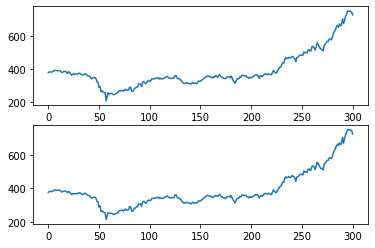

In [28]:
from matplotlib import pyplot as plt

examples = [i for i in range(batch_low_limit, batch_high_limit+1)]

fig, axs = plt.subplots(2)

y_temp = y_test[batch_low_limit : batch_high_limit+1]

axs[0].plot(y_temp[:, 1])
axs[1].plot(preds)
plt.show()

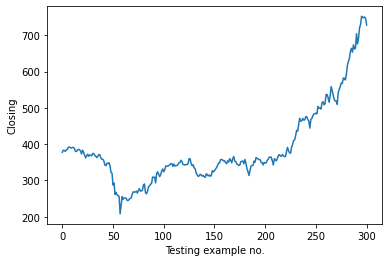

In [29]:
y_temp = y_test[batch_low_limit : batch_high_limit+1]

plt.plot(examples, y_temp[:, 1])
plt.xlabel("Testing example no.")
plt.ylabel("Closing")
plt.show()

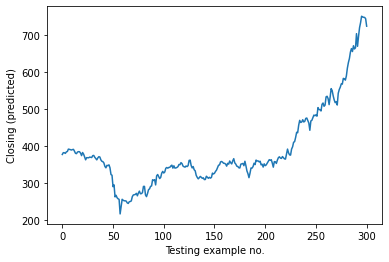

In [30]:
plt.plot(examples, preds)
plt.xlabel("Testing example no.")
plt.ylabel("Closing (predicted)")
plt.show()

In [31]:
from sklearn.metrics import r2_score

y_temp = y_test[batch_low_limit : batch_high_limit+1]
r2_score(y_temp[:, 1], preds)

0.9998410824250896

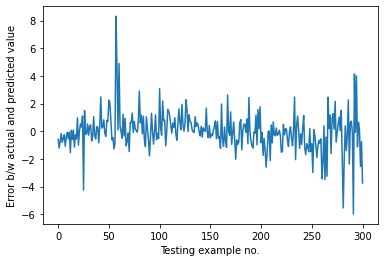

In [33]:
# 563

y = np.array(preds) - y_temp[:, 1].reshape((len(preds), 1))
plt.plot(y)
plt.xlabel("Testing example no.")
plt.ylabel("Error b/w actual and predicted value")
plt.show()

0-300 : 0.9998410824250896
301-600 : 0.9999088504958756
601-900 : 0.9999709809561002
901-1200 : 0.9999946162043326
1201-1500 : 0.9994534345692387